<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/Farm04.Selecao_Preditoras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Boruta # Run this if you do not have Boruta installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importação de Bibliotecas**


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer

from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings('once')

**Classe para imputação e coluna de missing**

In [3]:
class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def transformColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in self.col_name_with_nan :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia      

    def col_with_nan(self, X) -> list:
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(col)
      return list_col_with_nan

    def col_num_with_nan(self, X) -> list:
      cols = X.shape[1]
      list_col_with_nan = []
      for col in range(cols):    
          if(np.count_nonzero(np.isnan(X[:,col])) > 0) :  
              list_col_with_nan.append(col)
      return list_col_with_nan        

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_name_with_nan = None
      self.col_number_with_nan = None
      self.postfix = postfix

    def fit_DF(self, X):
      self.col_name = X.columns.values
      self.col_name_with_nan = self.col_with_nan(X)

    def fit_NP(self, X):
      self.col_number_with_nan = self.col_num_with_nan(X)

    def transform_DF(self, X):
      copia = self.transformColunas_IMPUTED(X)
      transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
      transformed.columns = X.columns
      transformed.index = X.index
      for col in self.col_name_with_nan :
        transformed[f'{col}{self.postfix}'] = copia[f'{col}{self.postfix}']
      return transformed

    def transform_NP(self, X):
      transformed = np.copy(X)
      vazio = np.zeros(shape=(X.shape[0], 0))
      for col in self.col_number_with_nan:
        a_nan = [1 if np.isnan(x) else 0 for x in transformed[:,col]]
        vazio = np.append(vazio, np.c_[a_nan], axis = 1)
      transformed = self.imputer.transform(transformed)  
      for col in range(vazio.shape[1]) :
        transformed = np.append(transformed, np.c_[vazio[:, col]], axis = 1)
      return transformed      

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        if(type(X) == pd.DataFrame) :
          self.fit_DF(X)
        else :
          self.fit_NP(X)  
        self.imputer.fit(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        if(self.col_name is not None) :
          transformed = self.transform_DF(X)    
        else :
          transformed = self.transform_NP(X)    
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self 

**Leitura dos Dados**


In [4]:
SEED = 48
np.random.seed(SEED)
warnings.filterwarnings(action='once')


resultados = []

df = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/farmaco.csv')
df.columns = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K', 'FARMACO']
preditoras = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K']
alvo = 'FARMACO'

X = df[preditoras]
y = df[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

print(f'Holdout: {X_train.shape[0]} individuos em treino. {X_test.shape[0]} individuos em teste.')

Holdout: 168 individuos em treino. 57 individuos em teste.


**Definindo pré-processamento e transformadores**

In [5]:
feature_list = ['PA', 'COLESTEROL', 'SEXO', 'IDADE', 'NA_K', 'IDADE_IMPUTED', 'PA_IMPUTED', 'COLESTEROL_IMPUTED', 'NA_K_IMPUTED']

ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], 
                                                                                     ['LOW', 'NORMAL', 'HIGH']], 
                                                                          handle_unknown='use_encoded_value',
                                                                          unknown_value=np.nan))
                                     ])
onehot_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])

col_transformer = ColumnTransformer(transformers=[('pa_colesterol', ordinal_transformer, ['PA', 'COLESTEROL']),
                                                  ('sex', onehot_transformer, ['SEXO'])],
                                    remainder='passthrough')

transformer = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()),
                              ('imputer', ImputerWithMissingMark())])

le = LabelEncoder()

**Ajustando pré-processadores**

In [6]:
le.fit(y_train)

tree = DecisionTreeClassifier(criterion='gini', max_depth=10, 
                              min_samples_leaf = 2, min_samples_split = 3, 
                              random_state=SEED)


modelo = Pipeline(steps=[('transformer', transformer),
                         ('classificador',  tree)])  

**Calculando o score do modelo original (com todas as features**)

In [7]:
def score_modelo(X_train, y_train, X_test, y_test) :
  tree = DecisionTreeClassifier(criterion='gini', max_depth=10, 
                                min_samples_leaf = 2, min_samples_split = 3, 
                                random_state=SEED)
  le = LabelEncoder()
  le.fit(y_train)
  tree.fit(X_train, le.transform(y_train))
  score_original = tree.score(X_test, le.transform(y_test))
  return X_train.shape[1], score_original

In [8]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)
qtde_var_original, score_original = score_modelo(X_train_transformed, y_train, X_test_transformed, y_test)
resultados.append(['original', qtde_var_original, score_original])
print(f'Score do modelo com {qtde_var_original} entradas: {np.round(score_original * 100, 5)}%')

Score do modelo com 9 entradas: 96.49123%


**Utilizando o PCA para reduzir as dimensões dos dados.**

In [9]:
modelo.fit(X_train, le.transform(y_train))
X_train_transformed = modelo['transformer'].transform(X_train)
dados_corr = pd.DataFrame(data=X_train_transformed, columns=feature_list).corr()
dados_corr


,PA,COLESTEROL,SEXO,IDADE,NA_K,IDADE_IMPUTED,PA_IMPUTED,COLESTEROL_IMPUTED,NA_K_IMPUTED
PA,1.000000,0.016277,0.020112,-0.012874,0.021938,-0.039317,-0.085148,-0.099207,-0.004225
COLESTEROL,0.016277,1.000000,-0.052433,-0.023870,0.029538,-0.195438,-0.021908,0.045444,-0.091921
SEXO,0.020112,-0.052433,1.000000,-0.034154,-0.098681,-0.018412,0.018432,-0.085139,-0.010501
IDADE,-0.012874,-0.023870,-0.034154,1.000000,-0.034278,-0.053335,0.039097,-0.006342,-0.086901
NA_K,0.021938,0.029538,-0.098681,-0.034278,1.000000,-0.098392,-0.012485,0.007638,-0.016346
IDADE_IMPUTED,-0.039317,-0.195438,-0.018412,-0.053335,-0.098392,1.000000,0.155048,-0.014892,-0.021124
PA_IMPUTED,-0.085148,-0.021908,0.018432,0.039097,-0.012485,0.155048,1.000000,0.441825,-0.019224
COLESTEROL_IMPUTED,-0.099207,0.045444,-0.085139,-0.006342,0.007638,-0.014892,0.441825,1.000000,-0.008494
NA_K_IMPUTED,-0.004225,-0.091921,-0.010501,-0.086901,-0.016346,-0.021124,-0.019224,-0.008494,1.000000


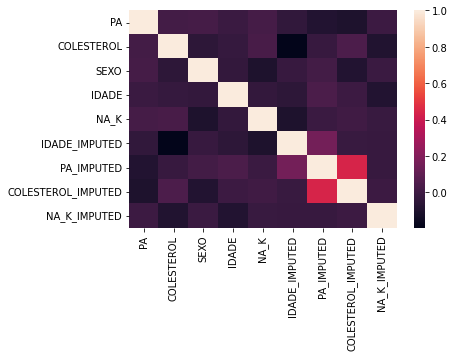

In [10]:
sns.heatmap(dados_corr)

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(transformer.transform(X_train))
variancia_explicada = pca.explained_variance_
print(variancia_explicada)

[1.12452815 1.03506426 0.97287438 0.96026222 0.87078314 0.03625483
 0.02669761 0.01158509 0.00442762]


In [12]:
pct_variancia_explicada = np.round((pca.explained_variance_ratio_) * 100, 2)
print(pct_variancia_explicada)

[22.3  20.53 19.29 19.04 17.27  0.72  0.53  0.23  0.09]


In [13]:
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(transformer.transform(X_train))
X_test_pca =  pca.transform(transformer.transform(X_test))
qtde_var_pca, score_pca = score_modelo(X_train_pca, y_train, X_test_pca, y_test)
resultados.append(['pca', qtde_var_pca, score_pca])
print(f'Score do modelo com {qtde_var_pca} entradas: {np.round(score_pca * 100, 5)}%')

Score do modelo com 4 entradas: 87.7193%


In [14]:
pct_variancia_explicada = np.round((pca.explained_variance_ratio_) * 100, 2)
print(pct_variancia_explicada)

[22.3  20.53 19.29 19.04]


**Utilizando o SelectKBest para reduzir a dimensão dos dados**

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2


transformer_kbest = Pipeline(steps=[('step_one', col_transformer), 
                                    ('min_max', MinMaxScaler(feature_range=(0, 2))),
                                    ('imputer', ImputerWithMissingMark())])


selectKBest = SelectKBest(chi2, k=4)

In [16]:
X_train_kbest = selectKBest.fit_transform(transformer_kbest.fit_transform(X_train), le.transform(y_train))
X_test_kbest =  selectKBest.transform(transformer_kbest.transform(X_test))
qtde_var_k_best, score_k_best = score_modelo(X_train_kbest, y_train, X_test_kbest, y_test)
resultados.append(['k_best', qtde_var_k_best, score_k_best])
print(f'Score do modelo com {qtde_var_k_best} entradas: {np.round(score_k_best * 100, 5)}%')

Score do modelo com 4 entradas: 87.7193%


**Utilizando a Eliminação Recursiva de Atributos para reduzir a dimensão dos dados**

In [17]:
from sklearn.feature_selection import RFE


rfe = RFE(estimator=tree, n_features_to_select=3, step=1)
rfe.fit(X_train_transformed, le.transform(y_train))
rfe.support_

cols_selected = rfe.support_.tolist()
for selected, feature_name in zip(cols_selected, feature_list) :
  if(selected) :
    print(feature_name)


PA
IDADE
NA_K


In [18]:
rank = rfe.ranking_
for pos, feature_name in zip(rank, feature_list) :
  print(pos, feature_name)

1 PA
5 COLESTEROL
7 SEXO
1 IDADE
1 NA_K
6 IDADE_IMPUTED
4 PA_IMPUTED
3 COLESTEROL_IMPUTED
2 NA_K_IMPUTED


**Utilizando o Boruta para reduzir a dimensão dos dados**

In [19]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
boruta = BorutaPy(rf, verbose=0, max_iter=20, random_state=SEED).fit(transformer.fit_transform(X_train), le.transform(y_train))

/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dec_reg = np.zeros(n_feat, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/boruta/boruta_py.py:265: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/re

In [20]:
cols_selected = boruta.support_.tolist()
for selected, feature_name in zip(cols_selected, feature_list) :
  if(selected) :
    print(feature_name)

PA
IDADE
NA_K


In [21]:
cols_weak = boruta.support_weak_.tolist()
for selected, feature_name in zip(cols_weak, feature_list) :
  if(selected) :
    print(feature_name)

In [22]:
rank = boruta.ranking_
for pos, feature_name in zip(rank, feature_list) :
  print(pos, feature_name)

1 PA
2 COLESTEROL
3 SEXO
1 IDADE
1 NA_K
4 IDADE_IMPUTED
5 PA_IMPUTED
6 COLESTEROL_IMPUTED
6 NA_K_IMPUTED


In [23]:
from sklearn.impute import SimpleImputer

SEED = 48

sel_preditoras = ['IDADE', 'PA', 'NA_K']
sel_alvo = 'FARMACO'

sel_X = df[sel_preditoras]
sel_y = df[sel_alvo]

sel_X_train, sel_X_test, sel_y_train, sel_y_test = train_test_split(sel_X, sel_y, test_size=0.25, stratify=sel_y, random_state=SEED)

tree = DecisionTreeClassifier(criterion='gini', max_depth=10, 
                               min_samples_leaf = 2, min_samples_split = 3)

sel_le = LabelEncoder()
sel_y_train_le = pd.Series(sel_le.fit_transform(sel_y_train))


sel_ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH']], 
                                                                             handle_unknown='use_encoded_value',
                                                                             unknown_value=np.nan))
                                     ])

sel_col_transformer = ColumnTransformer(transformers=[('pa', sel_ordinal_transformer, ['PA'])],
                                    remainder='passthrough')

sel_transformer = Pipeline(steps=[('step_one', sel_col_transformer), ('ss',  StandardScaler()), 
                                  ('imputer', SimpleImputer(strategy='median'))])

sel_modelo = Pipeline(steps=[('transformer', sel_transformer), ('classificador',  tree)]).fit(sel_X_train, sel_y_train_le)


score_var_boruta = sel_modelo.score(sel_X_test, le.transform(sel_y_test))


In [24]:
resultados.append(['boruta', sel_X_test.shape[1], score_var_boruta])
print(f'Score do modelo com {sel_X_test.shape[1]} entradas: {np.round(score_var_boruta * 100, 5)}%')

Score do modelo com 3 entradas: 96.49123%


In [25]:
resultados.append(['RFE', sel_X_test.shape[1], score_var_boruta])

In [26]:
import plotly.express as px
fig = px.scatter_3d(df, x='IDADE', y='PA', z='NA_K',
                    color='FARMACO')
fig.show()

In [27]:
dfResultados = pd.DataFrame(data = resultados, columns=['METODO', 'DIMENSOES', 'SCORE'])
dfResultados.SCORE = np.round(dfResultados.SCORE * 100, 4)
dfResultados

,METODO,DIMENSOES,SCORE
0,original,9,96.4912
1,pca,4,87.7193
2,k_best,4,87.7193
3,boruta,3,96.4912
4,RFE,3,96.4912


In [33]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator = tree, cv = 5, scoring = "accuracy", step = 1)
rfecv.fit(X_train_transformed, le.transform(y_train))
X_train_rfecv = rfecv.transform(X_train_transformed)
X_test_rfecv = rfecv.transform(X_test_transformed)
tree.fit(X_train_rfecv, le.transform(y_train))

print(tree.score(X_test_rfecv, le.transform(y_test)))


0.9473684210526315


In [34]:
cols_selected = rfecv.support_.tolist()
for selected, feature_name in zip(cols_selected, feature_list) :
  if(selected) :
    print(feature_name)

PA
IDADE
NA_K


In [60]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x = X_train_2d[:,0], y = X_train_2d[:,1], hue = y_train)

NameError: ignored

<Figure size 1008x576 with 0 Axes>

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
X_train_tnse = tsne.fit_transform(X_train_transformed)

plt.figure(figsize=(14, 8))
sns.scatterplot(x = X_train_tnse[:,0], y = X_train_tnse[:,1], hue = y_train)